## Comparison of freeze-thaw model's temperature against damping depth example
## Simulation Setup
    * High resolution vertical discretization (dz=0.125m) with depth = 4 m
    * Constant thermal conductivities ( TC = 2.2 W/(mK) -- typical value for saturated sandy soil)
    * Constant volumetic heat capacity 2.96E+6 [J/(m3*K)]
    * this leads to thermal diffusivity of 7.43E-6 [m2/s]

#### Algorithm 
* Get initial Soil Temperature profiles
* Call to PhaseChange is turned off, not needed here

#### Problem description

Thermal Diffusivity: $$ \alpha = \frac{K}{\rho * C_p} = \frac{\text{Thermal Conductivity}}{\text{volumetric heat capacity}}$$
Damping Depth: $$ \text{dd} = \sqrt{\frac{2 * \alpha}{\omega}}, \text{where} \, \omega = \frac{2 * \pi}{\tau}, \tau \, \text{is the period of the sine wave [in seconds]} $$
The damping depth [m] is the depth at which the amplitude of surface 
temperature oscillations is reduced by e−1 (about 37%). Below this depth the annual surface thermal signal does not penerate significantly .


For further notes:
* https://www.inscc.utah.edu/~krueger/6220/Arya_4.4_4.5.pdf
* https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2007wr005994


In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter 
import pandas as pd
import imageio, re
import json, os
import frozensoil as FS


#### Create an object/instance of the model, a configuration file is provided which is later used in the initialized step to initialize the state of the model at time t = 0

In [19]:
fs = FS.FrozenSoil(cfg_file='./configs/config_dd.json',tc_constant=True,standalone_HE=True)


#### Initialize the state of the model at the initial time, sets all the variables needed for phase partition and heat equation

In [20]:
fs.initialize()

#### All set for running the model and advancing the timestep. The forcing data (time series), if provided, will be used and the corresponding variables will be updated each time step at the model advancement stage

Damping depth = 2.731453754569566 2.731453754569566


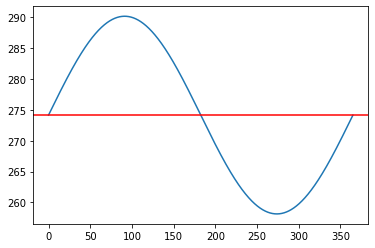

In [6]:
#set top surface temperature, if the boundary condition is not set here, the default is -12 degree C
cycles = fs.get_NTsteps() 
bc = np.zeros(cycles)

Tref = 273.15
Ta = 274.15 - Tref  # average temperature of the soil column
A0 = 274.15 - Tref + 15.0 # amplitude

tau= 365 * 86400 # period of the wave [s]
w = 2*np.pi / tau #[1/s]

P = 365*86400 #same as tua
Dh = 2.2 #thermal conductivity
VHC = 2.96E6 # volumetric heat capacity
alpha_h = Dh/VHC # thermal diffusivity

d = np.sqrt(2*alpha_h/w) ## damping depth
dd = np.sqrt(P*alpha_h/np.pi) ## damping depth

print ('Damping depth =',dd,d)
Time = []
t0=0
tm = 365*86400
for i in range(cycles):
    t1 = 3600 * i
    bc[i] = Tref + Ta + A0 * np.sin(2*np.pi/P*(t1-tm)) 
    Time.append(t1/86400.)
    
fs.set_surface_bc(bc)
plt.plot(Time, bc)
plt.axhline(274.15,color='r')


In [7]:
fs.run_model_forcing()

#### Postprocessing
#### Solution format: 0: time [s], 1: soil temperature [K], 2: liquid water [-], 3: total soil moisture [-]

In [8]:
solution = fs.get_solution()

In [ ]:
tt = []
for j in range(cycles):
    tt.append(np.mean(solution[j][1],axis=0))
print (np.mean(tt), np.max(tt), np.min(tt),)

8760


Text(0.5, 1.0, 'Surface temperature data used \n as a top boundary condition (at z=0)')

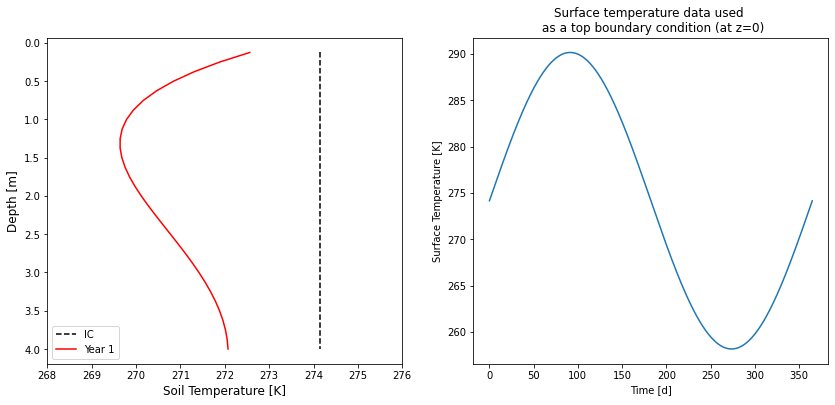

In [9]:
Z = [0.125,0.25,0.375,0.5,0.625,0.75,0.875,1.0,1.125,1.25,1.375,1.5,1.625,1.75,1.875,2.0,2.125,2.25,2.375,2.5,2.625,2.75,2.875,3.0,3.125,3.25,3.375,3.5,3.625,3.75,3.875,4.0]

fig, axs = plt.subplots(1,2,figsize=(14,6))
colors = ['r','g','k','m','c','y','b']
axs[0].plot(solution[0][1],Z, 'k-',label='IC',linestyle='dashed')
steps_per_yr = 24*365
print (steps_per_yr)
for i in range(1):
    x = steps_per_yr*(i+1)
    axs[0].plot(solution[x][1],Z, color=colors[i],label='Year %s'%(i+1))

axs[0].invert_yaxis()
axs[0].set_xlim(268,276)
axs[0].legend(loc='lower left')
axs[0].set_ylabel('Depth [m]',fontsize=12)
axs[0].set_xlabel('Soil Temperature [K]',fontsize=12)

axs[1].plot(Time, bc,)
axs[1].set_xlabel('Time [d]')
axs[1].set_ylabel('Surface Temperature [K]')

axs[1].set_title('Surface temperature data used \n as a top boundary condition (at z=0)')

In [11]:
#### Plot time series of soil temperature at several depths

Text(0, 0.5, 'Surface Temperature [K]')

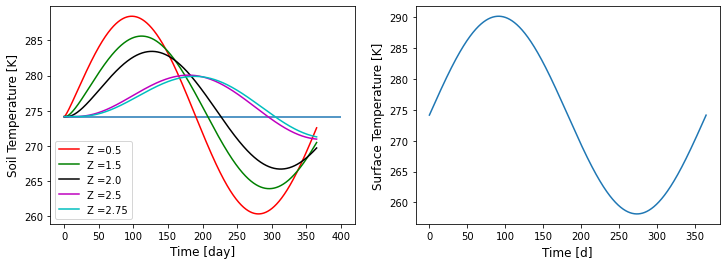

In [14]:
fig, axs = plt.subplots(1,2,figsize=(12,4))

T1, T2, T3,T4,T5 = [], [], [],[],[]
for j in range(cycles):
    T1.append(solution[j][1][0]) #0.25 m
    T2.append(solution[j][1][4]) # 1.0m
    T3.append(solution[j][1][8]) # 2.0 m
    T4.append(solution[j][1][20]) # 2.75 m
    T5.append(solution[j][1][22]) # 3.0 m

    
axs[0].plot(Time,T1, color=colors[0],label='Z =%s'%Z[3])
axs[0].plot(Time,T2, color=colors[1],label='Z =%s'%Z[11])
axs[0].plot(Time,T3, color=colors[2],label='Z =%s'%Z[15])
axs[0].plot(Time,T4, color=colors[3],label='Z =%s'%Z[19])
axs[0].plot(Time,T5, color=colors[4],label='Z =%s'%Z[21])

axs[0].set_ylabel('Soil Temperature [K]',fontsize=12)
axs[0].set_xlabel('Time [day]',fontsize=12)
axs[0].legend(loc='lower left')
axs[0].hlines(y=274.15, xmin=0,xmax=400)
axs[1].plot(Time, bc,)

axs[1].set_xlabel('Time [d]',fontsize=12)
axs[1].set_ylabel('Surface Temperature [K]',fontsize=12)

5.92 4.0 [5.872] 0.36787944117144233


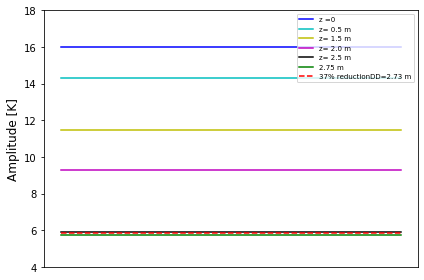

In [49]:
# find amplitude

DampingDepth = []
B1 = []
A1 = []
A2 = []
A3 = []
A4 = []
A5 = []
plt.tight_layout()
B1.append(A0)
DampingDepth.append(0.367*A0)
A1.append(np.max(T1) - 274.15)
A2.append(np.max(T2) - 274.15)
A3.append(np.max(T3) - 274.15)
A4.append(np.max(T4) - 274.15)
A5.append(np.max(T5) - 274.15)

plt.plot(np.ones(4)*B1,'b', label='z =0')
plt.plot(np.ones(4)*A1,'c',label='z= %s m'%Z[3])
plt.plot(np.ones(4)*A2,'y',label='z= %s m'%Z[11])
plt.plot(np.ones(4)*A3,'m',label='z= %s m'%Z[15])
plt.plot(np.ones(4)*A4,'k',label='z= %s m'%Z[19])
plt.plot(np.ones(4)*A5,'g',label='%s m'%Z[21])
plt.plot(np.ones(4)*DampingDepth,'r',linestyle='dashed',label='37% reduction'  +( "DD=%s m")%np.round(d,2))

plt.legend(loc='best',fontsize=7)#, bbox_to_anchor=(1.15, 0.4, 0.5, 0.5))
print (B1[0]*0.37,B1[0]*0.25,DampingDepth,np.exp(-1))
plt.xticks([])
plt.ylabel("Amplitude [K]",fontsize=12)
plt.ylim(4,18)
plt.tight_layout()
out_path = '/Users/ahmadjan/Core/SimulationsData/postprocessing/frozensoil/'
plt.savefig(out_path + '/damping_depth_test.png',dpi=200)

In [51]:
16*0.37

5.92